# Vectorization and Topic Analysis

In this notebook, we use sklearn's tf-idf vectorizer on our restaurant and business review corpus and perform topic analysis on the reviews.

## Import the modules and data

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import textacy
import pickle
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

In [2]:
with open('../data/tokenized.pkl', 'rb') as f:
    rests = pickle.load(f)

In [ ]:
with open('../data/tokenized_bs.pkl', 'rb') as bus:
    businesses = pickle.load(bus)

## Build the custom tf-idf vectorizer

Since I previously used spacy to tokenize the restaurant reviews, I can't use the default tf-idf vectorizer from sklearn since by default the vectorizer incorporates an analyzer, tokenizer, and preprocessor; we've already done the tokenizer and preprocessing in Notebook 2. I will need to construct a custom vectorizer using the tf-idf framework to vectorize our text for topic analysis.

In [3]:
def identity(doc):
    return doc

In [4]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=identity, preprocessor=identity, token_pattern=None, 
                             strip_accents='ascii', min_df=5, max_df=0.95, max_features=10000)

In [ ]:
lda_vec = TfidfVectorizer(analyzer='word', tokenizer=identity, preprocessor=identity, token_pattern=None, 
                             strip_accents='ascii', min_df=5, max_df=0.95, max_features=1000)

## Create document-term matrices for the two review corpora

In [5]:
doc_term_matrix = vectorizer.fit_transform((doc for doc in rests))

In [ ]:
doc_term_matrix_lda = lda_vec.fit_transform((doc for doc in rests))

## Create topic models and print out topics

Let's compare the topic generation of three decomposition models: Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), and non-Negative Matrix Factorization (NMF). Theoretically, LDA should perform better than NMF or LSA when it comes to creating coherent topics. 

In [6]:
def topics_and_top_docs(model, doc_topic_matrix, topics):
    for topic_idx, top_terms in model.top_topic_terms(vectorizer.get_feature_names()):
        print('topic', topic_idx, ':', '   '.join(top_terms))
    print('')
    for topic_idx, top_docs in model.top_topic_docs(doc_topic_matrix, topics=topics, top_n=2):
        print(topic_idx)
        for j in top_docs:
            print(rests[j])

### LDA

In [ ]:
lda = LatentDirichletAllocation(learning_method='online', batch_size=10000, n_jobs=-1, verbose=1)

In [ ]:
lda.fit(doc_term_matrix_lda)

In [ ]:
%%time 
lda_model = textacy.TopicModel(LatentDirichletAllocation(), n_topics=10, batch_size=10000, njobs=-1, verbose=1,
                               learning_method='online')
lda_model.fit(doc_term_matrix_lda)
doc_topic_matrix_lda = lda_model.transform(doc_term_matrix_lda)

In [ ]:
topics_and_top_docs(lda_model, doc_topic_matrix_lda, topics=[topic for topic in range(0, 10, 1)])

In [ ]:
lda.termite_plot(doc_term_matrix, vectorizer.get_feature_names(), topics=[num for num in range(0, 10, 1)])

### LSA

In [7]:
%%time
lsa_model = textacy.TopicModel('lsa', n_topics=100, n_jobs=-1)
lsa_model.fit(doc_term_matrix)
lsa_doc_topic_matrix = lsa_model.transform(doc_term_matrix)

CPU times: user 6min 54s, sys: 1min 5s, total: 8min
Wall time: 4min 36s


/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


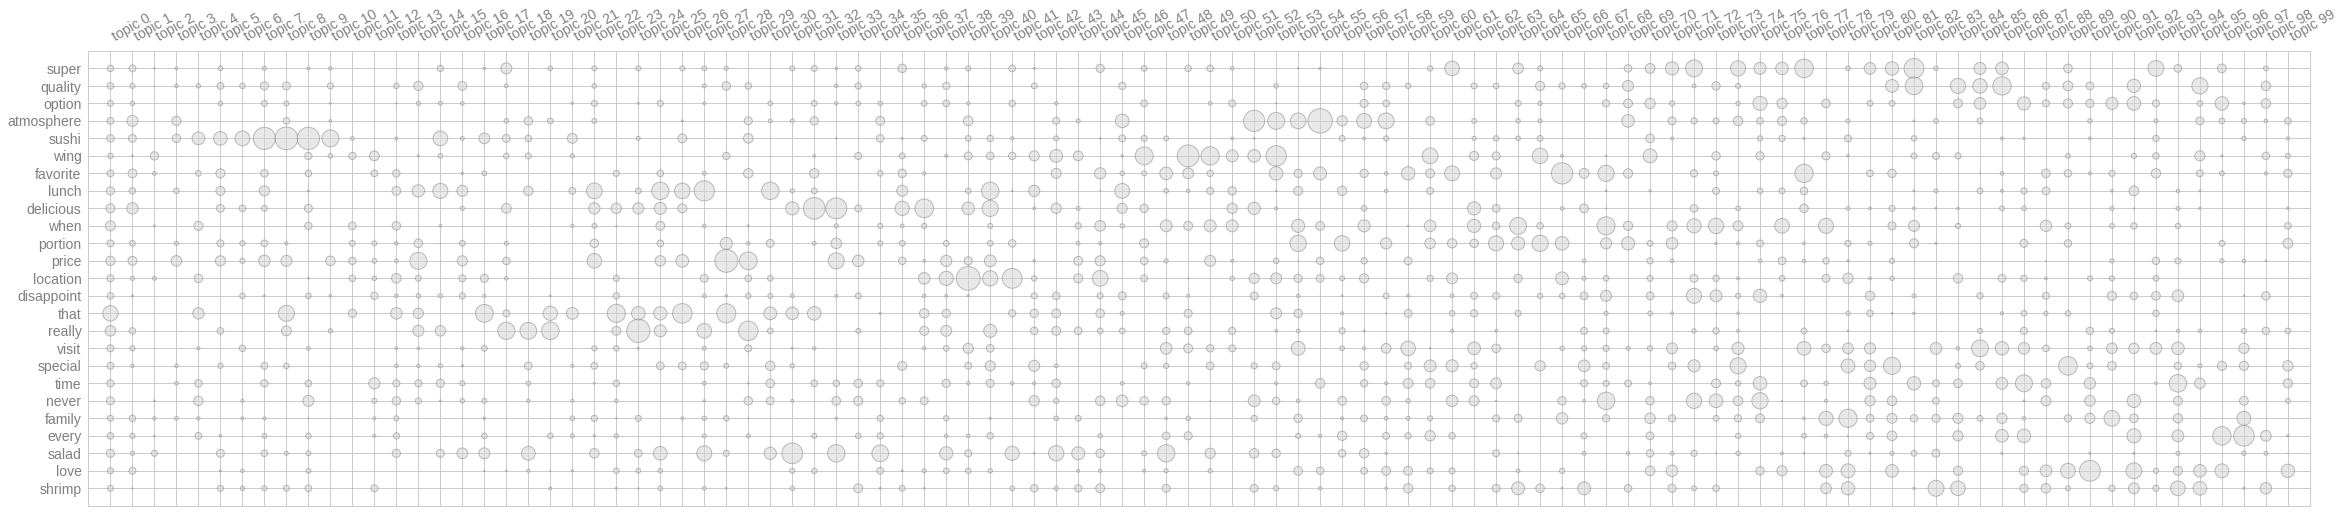

In [18]:
lsa_model.termite_plot(doc_term_matrix, vectorizer.get_feature_names(), topics=[num for num in range(0, 100, 1)])
plt.savefig('../visuals/lsa_termite.png')

In [21]:
topics_and_top_docs(lsa_model, lsa_doc_topic_matrix,  topics=[num for num in range(0, 25, 1)])

topic 0 : numb   be   that   this   they   with   place   have   great   order
topic 1 : great   place   service   friendly   very   amaze   always   staff   this   delicious
topic 2 : pizza   crust   slice   wing   cheese   topping   delivery   pepperoni   numb   sauce
topic 3 : numb   great   service   minute   price   atmosphere   friendly   star   staff   sushi
topic 4 : place   this   have   they   always   sushi   that   there   never   when
topic 5 : place   this   numb   chicken   sushi   fry   fresh   sandwich   price   sauce
topic 6 : very   sushi   this   restaurant   back   place   be   will   definitely   pizza
topic 7 : sushi   they   very   always   their   have   fresh   friendly   price   roll
topic 8 : sushi   great   that   much   with   price   roll   really   buffet   than
topic 9 : sushi   order   chicken   here   back   will   service   always   amaze   fry
topic 10 : burger   fry   sushi   very   burgers   friendly   they   staff   be   price
topic 11 : order   

0
['this', 'place', 'terrible', 'girlfriend', 'be', 'search', 'something', 'unique', 'stumble', 'upon', 'melt', 'last', 'night', 'have', 'never', 'fondue', 'hear', 'story', 'much', 'that', 'experience', 'that', 'everyone', 'should', 'sunday', 'night', 'expect', 'which', 'when', '\ufeff1', 'walk', 'hostess', 'very', 'polite', 'understand', 'they', 'decide', 'take', 'down', 'phone', 'numb', 'just', 'them', 'there', 'be', 'maybe', 'numb', 'numb', 'other', 'table', 'people', 'they', 'seat', 'back', 'restaurant', 'which', 'pretty', 'disrespectful', 'opinion', 'hostess', 'explain', 'work', 'drink', 'order', 'after', 'about', 'numb', 'minute', 'sit', 'there', 'still', 'drink', 'finally', 'server', 'ask', 'what', 'want', 'drink', 'polite', 'good', 'much', 'depth', 'suggest', 'that', 'order', 'numb', 'course', 'meal', 'after', 'another', 'numb', 'numb', 'minute', 'finally', 'glass', 'water', 'drink', 'be', 'sit', 'there', 'about', 'numb', 'numb', 'minute', 'without', 'even', 'water', 'sit', 'th

1
['great', 'coffeeeeeeeee', 'great', 'service', 'very', 'place']
['this', 'place', 'great', 'great', 'service']
2
['pizza', 'milagro', 'broma', 'milagro', 'pizza', 'milagro']
['superleckere', 'pizza', 'preislich', 'alles', 'wirklich', 'fahren', 'gerne', 'abends', 'setzten', 'biergarten']
3
['there', 'numb', 'numb', 'great', 'service']
['gehobenes', 'numb', 'numb', 'innenarchitektur', 'beschallung', 'angenehm', 'unaufdringlich', 'freundlicher', 'service', 'mittagstisch', 'abwechslung']
4
['that', 'this', 'place', 'place', 'this', 'place']
['this', 'place', 'this', 'place']
5
['this', 'place', 'numb', 'numb']
['this', 'place', 'yumma']
6
['very', 'sushi', 'place', 'will', 'definitely', 'back', 'staff', 'very', 'friendly']
['this', 'place', 'very', 'very', 'kkkkkkkkkkejdjeiwjjfnjdjwkkwjdndjskjfnjdjiwjndnndjdjsjsjdjdjd', 'jisjncn', 'jjjkskwn', 'jksjncnj', 'jjsjn', 'jkaknkck']
7
['sushi', 'have', 'their', 'take', 'always', 'delicious', 'sushi', 'bridgeville']
['sushi', 'very', 'sushi', 'va

### NMF

In [ ]:
%%time
nmf_model = textacy.TopicModel('nmf', n_topics=50, n_jobs=-1)
nmf_model.fit(doc_term_matrix)

In [ ]:
doc_topic_matrix_nmf = nmf_model.transform(doc_term_matrix)

In [ ]:
nmf_model.termite_plot(doc_term_matrix, vectorizer.get_feature_names(), topics=[num for num in range(0, 25, 1)])

In [ ]:
topics_and_top_docs(nmf_model, doc_topic_matrix_nmf, topics=[num for num in range(0, 25, 1)])

topic 0 : be   both   table   server   seat   time   disappoint   since   which   experience
topic 1 : great   atmosphere   price   selection   place   happy   fantastic   patio   music   service
topic 2 : pizza   crust   slice   cheese   wing   topping   pepperoni   delivery   sauce   italian
topic 3 : numb   minute   star   only   about   wait   give   after   people   hour
topic 4 : with   sauce   which   cheese   friend   side   some   also   flavor   sweet
topic 5 : place   this   look   about   from   favorite   review   location   find   vega
topic 6 : they   them   make   also   when   close   because   serve   offer   give
topic 7 : very   tasty   attentive   clean   good   also   portion   reasonable   small   price
topic 8 : sushi   roll   sashimi   salmon   quality   japanese   tempura   spicy   nigiri   happy
topic 9 : order   minute   take   when   wait   after   ask   wrong   call   then
topic 10 : burger   fry   burgers   cheese   onion   shake   bacon   patty   ring   

In [ ]:
nmf_model.save('../models/nmf.pkl')